In [0]:
##Install Pre trained pytorch bert model

!pip install pytorch-pretrained-bert

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.autograd import Variable
import torch.utils.data as data
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM

import logging
import urllib
import sys
import os
import zipfile
from os.path import join, exists



In [0]:
## Helper functions

def readData(file):
    data = pd.read_csv(file, delimiter='\t', header = None, skiprows=1)
    data.columns = ["pair_ID", "sentence_A", "sentence_B", "relatedness_score", "entailment_judgment"]
    return data

def column_values_tolist(output_list,df,col_name):
  for i in range(len(df)):
    output_list.append(df[col_name][i])
  return output_list

def encode_class_labels(ColumnAsList):
  for i in range(len(ColumnAsList)):
    if ColumnAsList[i] == 'CONTRADICTION':
      ColumnAsList [i] = 0
    elif ColumnAsList [i] == 'NEUTRAL':
      ColumnAsList [i] = 1
    elif ColumnAsList [i] == "ENTAILMENT":
      ColumnAsList [i] = 2
    else:
      pass
  return ColumnAsList

def decode_class_labels(ColumnAsList):
  for i in range(len(ColumnAsList)):
    if ColumnAsList[i] == 0:
      ColumnAsList [i] = 'CONTRADICTION'
    elif ColumnAsList [i] == 1:
      ColumnAsList [i] = 'NEUTRAL'
    elif ColumnAsList [i] == 2:
      ColumnAsList [i] = "ENTAILMENT"
    else:
      pass
  return ColumnAsList

def get_sent_em(sentence):
  text = sentence
  # Add the special tokens.
  marked_text = "[CLS] " + text + " [SEP]"
  # Split the sentence into tokens.
  tokenized_text = tokenizer.tokenize(marked_text)
  # Map the token strings to their vocabulary indeces.
  indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
  segments_ids = [1] * len(tokenized_text)
  tokens_tensor = torch.tensor([indexed_tokens])
  segments_tensors = torch.tensor([segments_ids])
  with torch.no_grad():
    encoded_layers, _ = model(tokens_tensor, segments_tensors)
  token_embeddings = torch.stack(encoded_layers, dim=0)
  token_embeddings = torch.squeeze(token_embeddings, dim=1)
  token_embeddings = token_embeddings.permute(1,0,2)
  token_vecs = encoded_layers[11][0]
  sentence_embedding = torch.mean(token_vecs, dim=0)
  return(sentence_embedding)


def get_bert_mean_pool(list_of_sentences):
  #passing list of sentences to this function
  output = list(map(get_sent_em,list_of_sentences))

  ## returns output which is list of tensors which are bert sentences embeddings with Mean pooling over bert word embeddings
  return output


def absolute_listoflists(u,v):

  ##returns abs value of u,v |u-v| where u, v are list of lists
  assert len(u) == len(v)
  inter_list = []
  final_list = []
  for i in range(len(u)):
    for j in range(len(u[0])):
      inter_list.append(abs(u[i][j]-v[i][j]))
    final_list.append(inter_list)
    inter_list = []
  return final_list



def final_embedding(u,v,auv):
  ## returns concatenated final embeddings [u,v,|u-v|]
  temp = u
  for i in range(len(u)):
    temp[i].extend(v[i])
    temp[i].extend(auv[i])

  return temp


In [0]:
def get_sbert_embeddings(dataframe):

  sentence_A_list = []

  sentence_A_list = column_values_tolist(sentence_A_list,dataframe,"sentence_A")

  sentence_B_list = []

  sentence_B_list = column_values_tolist(sentence_B_list,dataframe,"sentence_B")


## getting mean pool sentence embeddings from bert word embeddings

  sentence_A_meanpool_embedding = get_bert_mean_pool(sentence_A_list)

  sentence_B_meanpool_embedding = get_bert_mean_pool(sentence_B_list)

##output from above function is list of tensors and convertin them to list

  sent_A_list = [sentence_A_meanpool_embedding[i].tolist()  for i in range(len(sentence_A_meanpool_embedding))]

  sent_B_list = [sentence_B_meanpool_embedding[i].tolist()  for i in range(len(sentence_B_meanpool_embedding))]

##To get |u-v| for all the sentence embeddings in the list

  absoflists = absolute_listoflists(sent_A_list,sent_B_list)

##Final siamese network sentence embeddings (u,v,|u-v|)

  final_sent_embedding = final_embedding(sent_A_list,sent_B_list,absoflists)

  return final_sent_embedding



def df_for_task1(embeddings_list,dataframe):

  labels = []
  labels = column_values_tolist(labels,dataframe,"entailment_judgment")

  labels_list = encode_class_labels(labels)

  task1_df = pd.DataFrame.from_records(embeddings_list)

  task1_df.insert(2304,column='Outcome',value=labels_list)

  ## 0 for C , 1 for N and 2 for E

  return task1_df

In [0]:
##Dataset Class extends Pytorch inbuilt Dataset Class


class Arizona(Dataset):
  def __init__(self, file_path, transform=None):
        self.data = file_path
        self.transform = transform
        self.targets = [a for a in self.data.iloc[:,2304]]
        
  def __len__(self):
    return len(self.data)
    
  def __getitem__(self, index):
    sample = self.data.iloc[index, :-1].values.reshape((1,2304))
    label = self.targets[index]
        
    if self.transform is not None:
      sample = self.transform(sample)
            
    return sample,label

In [0]:
## Neural Network architecture is named Network and this extends Pytorch inbuit nn.Module class

class Network(nn.Module):
  def __init__(self):
    super(Network,self).__init__()
    self.out = nn.Linear(in_features=2304,out_features=3)

  def forward(self,t):
    #implement forward pass method
    t = t
    t = t.reshape(-1, 2304) ##dont think this is necessary recheck
    t = self.out(t)
    return t

In [0]:
#Load pre-trained model tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Load pre-trained model (weights)
model = BertModel.from_pretrained('bert-base-uncased')

# Put the model in "evaluation" mode, meaning feed-forward operation.
model.eval()

In [0]:
train_data = "http://www.site.uottawa.ca/~diana/csi5386/A2_2020/SICK_train.txt"
test_data ="http://www.site.uottawa.ca/~diana/csi5386/A2_2020/SICK_test_annotated.txt"
validation_data ="http://www.site.uottawa.ca/~diana/csi5386/A2_2020/SICK_trial.txt"


## Using helper function read_data to fetch dataset from link specified

train = readData(train_data)
validation = readData(validation_data)
test = readData(test_data)

In [0]:
##get Siamese network final embeddings and make a dataframe out of that embeddings

##Train

final_sent_embeddings = get_sbert_embeddings(train)

train_df = df_for_task1(final_sent_embedding,train)

##Validation

final_sent_embedding_val = get_sbert_embeddings(validation)

val_df = df_for_task1(final_sent_embedding_val,validation)

## TEST

final_sent_embedding_test = get_sbert_embeddings(test)

test_df = df_for_task1(final_sent_embedding_test,test)

## Torch Datasets,Dataloader formats of train,test and validation sets

## Train

train_dataset = Arizona(train_df,transform=torchvision.transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=300)

## Complete train set loader

total_train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=4500)

##Validation

val_dataset = Arizona(val_df,transform=torchvision.transforms.ToTensor())

val_loader = torch.utils.data.DataLoader(val_dataset,batch_size=500)

#Test

test_dataset = Arizona(test_df,transform=torchvision.transforms.ToTensor())

test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=4927)



MODEL : 1 
Batch_Size : 300 , optimizer : Adam , learning rate = 0.01 , Epochs : 15

In [0]:
##Creating an instance of Network class which is our model here

## BS : 300 , optimizer : Adam , learning rate = 0.01 , Epochs : 15

variant = Network()

In [0]:
## Initial Weights

variant.out.weight

Parameter containing:
tensor([[-1.7765e-02,  1.5199e-02, -5.9272e-03,  ..., -2.1108e-03,
          5.2874e-04, -4.7907e-05],
        [ 9.2264e-03, -9.1785e-03, -2.7190e-03,  ...,  1.0193e-02,
         -7.9999e-03,  1.9330e-02],
        [ 2.0256e-02, -1.0859e-02, -2.1908e-04,  ..., -1.5534e-02,
         -1.6485e-03,  1.6850e-02]], requires_grad=True)

In [0]:
## Creating an optimizer instance and passing it the learning rate

optimizer = optim.Adam(variant.parameters(),lr=0.01)

In [0]:
## Training and storing the model which performed the best on validation set

## Storing loss and accuracy to plot corresponding graphs


for batch_val in val_loader:
  images_val,labels_val = batch_val

for batch_test in test_loader:
  images_test,labels_test = batch_test

for batch_total in total_train_loader:
  images_total,labels_total = batch_total

train_loss = []
val_loss = []
train_accuracy = []
val_accuracy = []
max_acc_val = 0
for epoch in range(15):
  total_loss = 0
  loss_val = 0
  for batch in train_loader:
    images,labels = batch
    preds = variant(images.float())

    loss = F.cross_entropy(preds,labels)
    

    optimizer.zero_grad()

    loss.backward()
    optimizer.step()

    total_loss += loss.item()
  preds_val = variant(images_val.float())
  loss_val = F.cross_entropy(preds_val,labels_val)
  loss_val = loss_val.item()
  train_loss.append(total_loss)
  val_loss.append(loss_val)
  train_acc = preds.argmax(dim=1).eq(labels).sum().item()/len(images)
  train_accuracy.append(train_acc)
  val_acc = preds_val.argmax(dim=1).eq(labels_val).sum().item()/len(images_val)
  val_accuracy.append(val_acc)
  if val_acc > max_acc_val:
    max_acc_val = val_acc
    torch.save(variant.state_dict(), "/content/best_variant_model.pt")
    print("saved model now")
  print("epoch: ",epoch , "loss: ",total_loss)
  print("epoch: ",epoch , "loss_val: ",loss_val)
  print("epoch: ",epoch , "train_accuracy: ",train_acc)
  print("epoch: ",epoch , "val_accuracy: ",val_acc)

saved model now
epoch:  0 loss:  13.213411569595337
epoch:  0 loss_val:  0.890512228012085
epoch:  0 train_accuracy:  0.7666666666666667
epoch:  0 val_accuracy:  0.65
epoch:  1 loss:  10.638350903987885
epoch:  1 loss_val:  1.266083836555481
epoch:  1 train_accuracy:  0.7633333333333333
epoch:  1 val_accuracy:  0.614
epoch:  2 loss:  11.693186819553375
epoch:  2 loss_val:  0.990885317325592
epoch:  2 train_accuracy:  0.7833333333333333
epoch:  2 val_accuracy:  0.644
saved model now
epoch:  3 loss:  10.02355346083641
epoch:  3 loss_val:  0.755164384841919
epoch:  3 train_accuracy:  0.7866666666666666
epoch:  3 val_accuracy:  0.674
saved model now
epoch:  4 loss:  8.37997379899025
epoch:  4 loss_val:  0.6751585006713867
epoch:  4 train_accuracy:  0.82
epoch:  4 val_accuracy:  0.692
saved model now
epoch:  5 loss:  7.737139940261841
epoch:  5 loss_val:  0.6452306509017944
epoch:  5 train_accuracy:  0.8266666666666667
epoch:  5 val_accuracy:  0.708
saved model now
epoch:  6 loss:  7.403574

In [0]:
## Validation accuracy list containing epoch number of items

val_accuracy

[0.65,
 0.614,
 0.644,
 0.674,
 0.692,
 0.708,
 0.714,
 0.714,
 0.714,
 0.706,
 0.714,
 0.716,
 0.716,
 0.714,
 0.706]

In [0]:
## Classification Report for a single batch of samples from train set

from sklearn.metrics import classification_report
target_names = ['CONTRADICTION', 'NEUTRAL', 'ENTAILMENT']
print(classification_report(labels.numpy(),preds.argmax(dim=1).numpy(), target_names=target_names))

               precision    recall  f1-score   support

CONTRADICTION       1.00      0.85      0.92        20
      NEUTRAL       0.92      0.90      0.91       224
   ENTAILMENT       0.65      0.75      0.69        56

     accuracy                           0.87       300
    macro avg       0.86      0.83      0.84       300
 weighted avg       0.88      0.87      0.87       300



In [0]:
## Classification Report of Validation Set 

from sklearn.metrics import classification_report
target_names = ['CONTRADICTION', 'NEUTRAL', 'ENTAILMENT']
print(classification_report(labels_val.numpy(),preds_val.argmax(dim=1).numpy(), target_names=target_names))

               precision    recall  f1-score   support

CONTRADICTION       0.91      0.28      0.43        74
      NEUTRAL       0.70      0.90      0.78       282
   ENTAILMENT       0.70      0.55      0.61       144

     accuracy                           0.71       500
    macro avg       0.77      0.58      0.61       500
 weighted avg       0.73      0.71      0.68       500



In [0]:
## Passing complete train loader to the model for train predictions

preds_total = variant(images_total.float())

In [0]:
## Classification Report for Complete Train set

from sklearn.metrics import classification_report
target_names = ['CONTRADICTION', 'NEUTRAL', 'ENTAILMENT']
print(classification_report(labels_total.numpy(),preds_total.argmax(dim=1).numpy(), target_names=target_names))

               precision    recall  f1-score   support

CONTRADICTION       0.99      0.48      0.65       665
      NEUTRAL       0.76      0.92      0.83      2536
   ENTAILMENT       0.79      0.66      0.72      1299

     accuracy                           0.78      4500
    macro avg       0.85      0.69      0.73      4500
 weighted avg       0.80      0.78      0.77      4500



In [0]:
## Getting predictions on test set

preds_test = variant(images_test.float())

In [0]:
## Classification Report for Test set

from sklearn.metrics import classification_report
target_names = ['CONTRADICTION', 'NEUTRAL', 'ENTAILMENT']
print(classification_report(labels_test.numpy(),preds_test.argmax(dim=1).numpy(), target_names=target_names))

               precision    recall  f1-score   support

CONTRADICTION       0.97      0.36      0.53       720
      NEUTRAL       0.71      0.90      0.79      2793
   ENTAILMENT       0.70      0.56      0.62      1414

     accuracy                           0.72      4927
    macro avg       0.79      0.61      0.65      4927
 weighted avg       0.75      0.72      0.71      4927



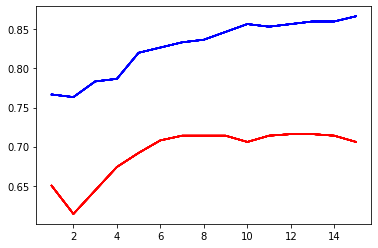

In [0]:
## Plot Showing the accuracy of validation and train set with respect to epochs 
for i in range(len(epoch)):
  plt.plot(epoch,train_accuracy,'b')
  plt.plot(epoch,val_accuracy,'r')

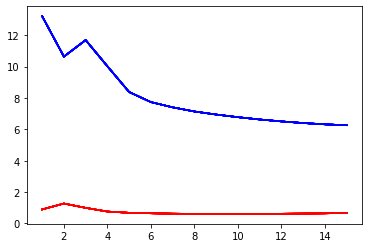

In [0]:
## Plot showing loss of Validation and Train Sets with epochs 

for i in range(len(epoch)):
  plt.plot(epoch,train_loss,'b')
  plt.plot(epoch,val_loss,'r')

In [0]:
test_report_values = preds_test.argmax(dim=1).numpy()

test_report_values = test_report_values.tolist()

output_test_values = decode_class_labels(test_report_values)

MODEL - 2 : Batch size : 500 , lr = 0.01 , optim : ADAM


In [0]:
network = Network()
torch.set_grad_enabled(True)

optimizer = optim.Adam(network.parameters(),lr=0.01)

In [0]:
network.out.weight

Parameter containing:
tensor([[-0.0117, -0.0179,  0.0056,  ...,  0.0108, -0.0190, -0.0060],
        [-0.0006, -0.0145,  0.0057,  ..., -0.0122,  0.0143, -0.0107],
        [ 0.0196,  0.0080, -0.0165,  ..., -0.0024, -0.0068, -0.0018]],
       requires_grad=True)

In [0]:
for batch_val in val_loader:
  images_val,labels_val = batch_val

for batch_test in test_loader:
  images_test,labels_test = batch_test

for batch_total in total_train_loader:
  images_total,labels_total = batch_total


for epoch in range(10):
  total_loss = 0
  loss_val = 0
  for batch in train_loader:
    images,labels = batch
    preds = network(images.float())

    loss = F.cross_entropy(preds,labels)
    

    optimizer.zero_grad()

    loss.backward()
    optimizer.step()

    total_loss += loss.item()
  preds_val = network(images_val.float())
  loss_val = F.cross_entropy(preds_val,labels_val)
  loss_val = loss_val.item()
  print("epoch :",epoch , "loss:",total_loss)
  print("epoch :",epoch , "loss_val",loss_val)

epoch : 0 loss: 17.883699655532837
epoch : 0 loss_val tensor(1.1273, grad_fn=<NllLossBackward>)
epoch : 1 loss: 8.71108865737915
epoch : 1 loss_val tensor(1.0293, grad_fn=<NllLossBackward>)
epoch : 2 loss: 9.961841225624084
epoch : 2 loss_val tensor(1.1528, grad_fn=<NllLossBackward>)
epoch : 3 loss: 7.679422438144684
epoch : 3 loss_val tensor(0.9003, grad_fn=<NllLossBackward>)
epoch : 4 loss: 7.495889365673065
epoch : 4 loss_val tensor(0.9569, grad_fn=<NllLossBackward>)
epoch : 5 loss: 7.170769393444061
epoch : 5 loss_val tensor(1.1383, grad_fn=<NllLossBackward>)
epoch : 6 loss: 8.017626881599426
epoch : 6 loss_val tensor(0.8922, grad_fn=<NllLossBackward>)
epoch : 7 loss: 6.911933064460754
epoch : 7 loss_val tensor(0.6624, grad_fn=<NllLossBackward>)
epoch : 8 loss: 5.599253535270691
epoch : 8 loss_val tensor(1.1837, grad_fn=<NllLossBackward>)
epoch : 9 loss: 9.077141910791397
epoch : 9 loss_val tensor(0.9703, grad_fn=<NllLossBackward>)


In [0]:
## Batch Report

from sklearn.metrics import classification_report
target_names = ['CONTRADICTION', 'NEUTRAL', 'ENTAILMENT']
print(classification_report(labels.numpy(),preds.argmax(dim=1).numpy(), target_names=target_names))

               precision    recall  f1-score   support

CONTRADICTION       0.83      0.81      0.82        37
      NEUTRAL       0.84      0.87      0.86       351
   ENTAILMENT       0.58      0.51      0.54       112

     accuracy                           0.79       500
    macro avg       0.75      0.73      0.74       500
 weighted avg       0.78      0.79      0.78       500



In [0]:
##validation report

from sklearn.metrics import classification_report
target_names = ['CONTRADICTION', 'NEUTRAL', 'ENTAILMENT']
print(classification_report(labels_val.numpy(),preds_val.argmax(dim=1).numpy(), target_names=target_names))

               precision    recall  f1-score   support

CONTRADICTION       0.93      0.57      0.71        74
      NEUTRAL       0.63      0.98      0.77       282
   ENTAILMENT       0.74      0.10      0.17       144

     accuracy                           0.66       500
    macro avg       0.77      0.55      0.55       500
 weighted avg       0.71      0.66      0.59       500



In [0]:
preds_total = network(images_total.float())
preds_test = network(images_test.float())

In [0]:
##Train Report

from sklearn.metrics import classification_report
target_names = ['CONTRADICTION', 'NEUTRAL', 'ENTAILMENT']
print(classification_report(labels_total.numpy(),preds_total.argmax(dim=1).numpy(), target_names=target_names))

               precision    recall  f1-score   support

CONTRADICTION       0.89      0.64      0.75       665
      NEUTRAL       0.64      0.98      0.77      2536
   ENTAILMENT       0.78      0.09      0.16      1299

     accuracy                           0.67      4500
    macro avg       0.77      0.57      0.56      4500
 weighted avg       0.72      0.67      0.59      4500



In [0]:
##Test Report

from sklearn.metrics import classification_report
target_names = ['CONTRADICTION', 'NEUTRAL', 'ENTAILMENT']
print(classification_report(labels_test.numpy(),preds_test.argmax(dim=1).numpy(), target_names=target_names))

               precision    recall  f1-score   support

CONTRADICTION       0.85      0.59      0.69       720
      NEUTRAL       0.64      0.97      0.77      2793
   ENTAILMENT       0.71      0.08      0.15      1414

     accuracy                           0.66      4927
    macro avg       0.73      0.55      0.54      4927
 weighted avg       0.69      0.66      0.58      4927



MODEL - 3 : Batch_size : 450 , lr = 0.01 , Epoch : 10 , Optimiser : Adam

In [0]:

network3 = Network()
torch.set_grad_enabled(True)

optimizer = optim.Adam(network3.parameters(),lr=0.01)

In [0]:
network3.out.weight

Parameter containing:
tensor([[ 1.5798e-02, -8.5288e-03,  2.8776e-03,  ...,  7.1720e-04,
         -5.9858e-03,  1.5092e-03],
        [ 1.6869e-02, -8.1383e-05,  2.0362e-02,  ...,  1.5685e-02,
         -1.9940e-02, -2.0471e-02],
        [-1.8806e-02, -4.5142e-03,  6.7065e-03,  ...,  3.1820e-04,
         -4.2766e-03,  1.1295e-02]], requires_grad=True)

In [0]:
for batch_val in val_loader:
  images_val,labels_val = batch_val

for batch_test in test_loader:
  images_test,labels_test = batch_test

for batch_total in total_train_loader:
  images_total,labels_total = batch_total

for epoch in range(10):
  total_loss = 0
  loss_val = 0
  for batch in train_loader:
    images,labels = batch
    preds = network3(images.float())

    loss = F.cross_entropy(preds,labels)
    

    optimizer.zero_grad()

    loss.backward()
    optimizer.step()

    total_loss += loss.item()
  preds_val = network3(images_val.float())
  loss_val = F.cross_entropy(preds_val,labels_val)
  loss_val = loss_val.item()
  print("epoch :",epoch , "loss:",total_loss)
  print("epoch :",epoch , "loss_val",loss_val)

epoch : 0 loss: 19.208307802677155
epoch : 0 loss_val 1.3388372659683228
epoch : 1 loss: 8.823934197425842
epoch : 1 loss_val 0.8915795683860779
epoch : 2 loss: 8.579093217849731
epoch : 2 loss_val 1.1420402526855469
epoch : 3 loss: 9.986639678478241
epoch : 3 loss_val 1.0065624713897705
epoch : 4 loss: 8.012901544570923
epoch : 4 loss_val 0.8825651407241821
epoch : 5 loss: 8.561456799507141
epoch : 5 loss_val 0.8321762681007385
epoch : 6 loss: 8.240012466907501
epoch : 6 loss_val 0.8698725700378418
epoch : 7 loss: 9.350363731384277
epoch : 7 loss_val 1.5328618288040161
epoch : 8 loss: 10.995227992534637
epoch : 8 loss_val 1.0808160305023193
epoch : 9 loss: 10.815921545028687
epoch : 9 loss_val 0.7061193585395813


In [0]:
## Batch Report 

from sklearn.metrics import classification_report
target_names = ['CONTRADICTION', 'NEUTRAL', 'ENTAILMENT']``
print(classification_report(labels.numpy(),preds.argmax(dim=1).numpy(), target_names=target_names))

               precision    recall  f1-score   support

CONTRADICTION       0.84      0.74      0.79        35
      NEUTRAL       0.80      0.91      0.85       317
   ENTAILMENT       0.56      0.33      0.41        98

     accuracy                           0.77       450
    macro avg       0.73      0.66      0.68       450
 weighted avg       0.75      0.77      0.75       450



In [0]:
preds_total = network3(images_total.float())

In [0]:
## Train Report

from sklearn.metrics import classification_report
target_names = ['CONTRADICTION', 'NEUTRAL', 'ENTAILMENT']
print(classification_report(labels_total.numpy(),preds_total.argmax(dim=1).numpy(), target_names=target_names))

               precision    recall  f1-score   support

CONTRADICTION       0.69      0.90      0.78       665
      NEUTRAL       0.80      0.79      0.79      2536
   ENTAILMENT       0.69      0.59      0.64      1299

     accuracy                           0.75      4500
    macro avg       0.73      0.76      0.74      4500
 weighted avg       0.75      0.75      0.75      4500



In [0]:
## Validation Report

from sklearn.metrics import classification_report
target_names = ['CONTRADICTION', 'NEUTRAL', 'ENTAILMENT']
print(classification_report(labels_val.numpy(),preds_val.argmax(dim=1).numpy(), target_names=target_names))

               precision    recall  f1-score   support

CONTRADICTION       0.64      0.82      0.72        74
      NEUTRAL       0.79      0.80      0.79       282
   ENTAILMENT       0.69      0.56      0.62       144

     accuracy                           0.74       500
    macro avg       0.71      0.73      0.71       500
 weighted avg       0.74      0.74      0.73       500



In [0]:
preds_test = network3(images_test.float())

In [0]:
## Test Report


from sklearn.metrics import classification_report
target_names = ['CONTRADICTION', 'NEUTRAL', 'ENTAILMENT']
print(classification_report(labels_test.numpy(),preds_test.argmax(dim=1).numpy(), target_names=target_names))

               precision    recall  f1-score   support

CONTRADICTION       0.66      0.85      0.74       720
      NEUTRAL       0.78      0.78      0.78      2793
   ENTAILMENT       0.65      0.55      0.60      1414

     accuracy                           0.73      4927
    macro avg       0.70      0.73      0.71      4927
 weighted avg       0.73      0.73      0.73      4927



MODEL - 4 : Optim : SGD , Batch_Size : 450 , lr = 0.01 , Epoch : 20

In [0]:
network4 = Network()

torch.set_grad_enabled(True)

optimizer = optim.SGD(network4.parameters(),lr=0.01)

In [0]:
for batch_val in val_loader:
  images_val,labels_val = batch_val

for batch_test in test_loader:
  images_test,labels_test = batch_test

for batch_total in total_train_loader:
  images_total,labels_total = batch_total

for epoch in range(20):
  total_loss = 0
  loss_val = 0
  for batch in train_loader:
    images,labels = batch
    preds = network4(images.float())

    loss = F.cross_entropy(preds,labels)
    

    optimizer.zero_grad()

    loss.backward()
    optimizer.step()

    total_loss += loss.item()
  preds_val = network4(images_val.float())
  loss_val = F.cross_entropy(preds_val,labels_val)
  loss_val = loss_val.item()
  print("epoch :",epoch , "loss:",total_loss)
  print("epoch :",epoch , "loss_val",loss_val)

epoch : 0 loss: 9.640519738197327
epoch : 0 loss_val 0.9535475969314575
epoch : 1 loss: 9.307648420333862
epoch : 1 loss_val 0.9348976612091064
epoch : 2 loss: 9.131895005702972
epoch : 2 loss_val 0.9174870848655701
epoch : 3 loss: 8.970506250858307
epoch : 3 loss_val 0.9014794826507568
epoch : 4 loss: 8.822626173496246
epoch : 4 loss_val 0.8867390155792236
epoch : 5 loss: 8.686763644218445
epoch : 5 loss_val 0.8731305003166199
epoch : 6 loss: 8.561583340168
epoch : 6 loss_val 0.8605356216430664
epoch : 7 loss: 8.445911943912506
epoch : 7 loss_val 0.8488492965698242
epoch : 8 loss: 8.338719308376312
epoch : 8 loss_val 0.8379791975021362
epoch : 9 loss: 8.239106893539429
epoch : 9 loss_val 0.8278439044952393
epoch : 10 loss: 8.146288275718689
epoch : 10 loss_val 0.8183720111846924
epoch : 11 loss: 8.059570968151093
epoch : 11 loss_val 0.809499979019165
epoch : 12 loss: 7.978349387645721
epoch : 12 loss_val 0.8011719584465027
epoch : 13 loss: 7.902089715003967
epoch : 13 loss_val 0.79333

In [0]:
## Batch Report 

from sklearn.metrics import classification_report
target_names = ['CONTRADICTION', 'NEUTRAL', 'ENTAILMENT']
print(classification_report(labels.numpy(),preds.argmax(dim=1).numpy(), target_names=target_names))

               precision    recall  f1-score   support

CONTRADICTION       0.00      0.00      0.00        35
      NEUTRAL       0.75      0.91      0.82       317
   ENTAILMENT       0.48      0.31      0.37        98

     accuracy                           0.71       450
    macro avg       0.41      0.40      0.40       450
 weighted avg       0.63      0.71      0.66       450



In [0]:
preds_total = network4(images_total.float())

In [0]:
## Train Report

from sklearn.metrics import classification_report
target_names = ['CONTRADICTION', 'NEUTRAL', 'ENTAILMENT']
print(classification_report(labels_total.numpy(),preds_total.argmax(dim=1).numpy(), target_names=target_names))

               precision    recall  f1-score   support

CONTRADICTION       0.95      0.06      0.11       665
      NEUTRAL       0.59      0.96      0.73      2536
   ENTAILMENT       0.66      0.19      0.29      1299

     accuracy                           0.60      4500
    macro avg       0.73      0.40      0.38      4500
 weighted avg       0.67      0.60      0.51      4500



In [0]:
## Validation Report

from sklearn.metrics import classification_report
target_names = ['CONTRADICTION', 'NEUTRAL', 'ENTAILMENT']
print(classification_report(labels_val.numpy(),preds_val.argmax(dim=1).numpy(), target_names=target_names))

               precision    recall  f1-score   support

CONTRADICTION       1.00      0.03      0.05        74
      NEUTRAL       0.59      0.95      0.73       282
   ENTAILMENT       0.60      0.17      0.27       144

     accuracy                           0.59       500
    macro avg       0.73      0.38      0.35       500
 weighted avg       0.65      0.59      0.50       500



In [0]:
preds_test = network4(images_test.float())

In [0]:
## Test Report

from sklearn.metrics import classification_report
target_names = ['CONTRADICTION', 'NEUTRAL', 'ENTAILMENT']
print(classification_report(labels_test.numpy(),preds_test.argmax(dim=1).numpy(), target_names=target_names))

               precision    recall  f1-score   support

CONTRADICTION       0.90      0.05      0.09       720
      NEUTRAL       0.59      0.96      0.73      2793
   ENTAILMENT       0.63      0.17      0.27      1414

     accuracy                           0.60      4927
    macro avg       0.71      0.39      0.37      4927
 weighted avg       0.65      0.60      0.51      4927



Model 5 : Optim : Adam , lr = 0.001 , Epoch : 20 , Batch_size : 300

BEST MODEL

In [0]:
##Instance of Model

variant1 = Network()

torch.set_grad_enabled(True)

optimizer = optim.Adam(variant1.parameters(),lr=0.001)

In [0]:
# Training loop :

for batch_val in val_loader:
  images_val,labels_val = batch_val

for batch_test in test_loader:
  images_test,labels_test = batch_test

for batch_total in total_train_loader:
  images_total,labels_total = batch_total

train_loss = []
val_loss = []
train_accuracy = []
val_accuracy = []
max_acc_val = 0
for epoch in range(20):
  total_loss = 0
  loss_val = 0
  for batch in train_loader:
    images,labels = batch
    preds = variant1(images.float())

    loss = F.cross_entropy(preds,labels)
    

    optimizer.zero_grad()

    loss.backward()
    optimizer.step()

    total_loss += loss.item()
  preds_val = variant1(images_val.float())
  loss_val = F.cross_entropy(preds_val,labels_val)
  loss_val = loss_val.item()
  train_loss.append(total_loss)
  val_loss.append(loss_val)
  train_acc = preds.argmax(dim=1).eq(labels).sum().item()/len(images)
  train_accuracy.append(train_acc)
  val_acc = preds_val.argmax(dim=1).eq(labels_val).sum().item()/len(images_val)
  val_accuracy.append(val_acc)
  if val_acc > max_acc_val:
    max_acc_val = val_acc
    torch.save(variant1.state_dict(), "/content/best_variant_model.pt")
    print("saved model now")
  print("epoch: ",epoch , "loss: ",total_loss)
  print("epoch: ",epoch , "loss_val: ",loss_val)
  print("epoch: ",epoch , "train_accuracy: ",train_acc)
  print("epoch: ",epoch , "val_accuracy: ",val_acc)

saved model now
epoch:  0 loss:  12.320497274398804
epoch:  0 loss_val:  0.8457674384117126
epoch:  0 train_accuracy:  0.7466666666666667
epoch:  0 val_accuracy:  0.564
saved model now
epoch:  1 loss:  11.77094852924347
epoch:  1 loss_val:  0.7303366661071777
epoch:  1 train_accuracy:  0.7566666666666667
epoch:  1 val_accuracy:  0.594
saved model now
epoch:  2 loss:  11.418172299861908
epoch:  2 loss_val:  0.6947782039642334
epoch:  2 train_accuracy:  0.7366666666666667
epoch:  2 val_accuracy:  0.738
epoch:  3 loss:  10.399484097957611
epoch:  3 loss_val:  0.6869077682495117
epoch:  3 train_accuracy:  0.75
epoch:  3 val_accuracy:  0.73
saved model now
epoch:  4 loss:  10.00487071275711
epoch:  4 loss_val:  0.6245430111885071
epoch:  4 train_accuracy:  0.7766666666666666
epoch:  4 val_accuracy:  0.748
saved model now
epoch:  5 loss:  9.278306782245636
epoch:  5 loss_val:  0.6122738122940063
epoch:  5 train_accuracy:  0.7866666666666666
epoch:  5 val_accuracy:  0.756
saved model now
epoc

In [0]:
preds_total = variant1(images_total.float())

In [0]:
## Train Report

from sklearn.metrics import classification_report
target_names = ['CONTRADICTION', 'NEUTRAL', 'ENTAILMENT']
print(classification_report(labels_total.numpy(),preds_total.argmax(dim=1).numpy(), target_names=target_names))

               precision    recall  f1-score   support

CONTRADICTION       0.87      0.83      0.85       665
      NEUTRAL       0.84      0.82      0.83      2536
   ENTAILMENT       0.70      0.75      0.72      1299

     accuracy                           0.80      4500
    macro avg       0.80      0.80      0.80      4500
 weighted avg       0.80      0.80      0.80      4500



In [0]:
preds_test = variant1(images_test.float())

In [0]:
## Test Report

from sklearn.metrics import classification_report
target_names = ['CONTRADICTION', 'NEUTRAL', 'ENTAILMENT']
print(classification_report(labels_test.numpy(),preds_test.argmax(dim=1).numpy(), target_names=target_names))

               precision    recall  f1-score   support

CONTRADICTION       0.85      0.76      0.80       720
      NEUTRAL       0.81      0.80      0.81      2793
   ENTAILMENT       0.66      0.70      0.68      1414

     accuracy                           0.77      4927
    macro avg       0.77      0.76      0.76      4927
 weighted avg       0.77      0.77      0.77      4927



In [0]:
## Validation Report

from sklearn.metrics import classification_report
target_names = ['CONTRADICTION', 'NEUTRAL', 'ENTAILMENT']
print(classification_report(labels_val.numpy(),preds_val.argmax(dim=1).numpy(), target_names=target_names))

               precision    recall  f1-score   support

CONTRADICTION       0.88      0.76      0.81        74
      NEUTRAL       0.82      0.82      0.82       282
   ENTAILMENT       0.68      0.72      0.70       144

     accuracy                           0.78       500
    macro avg       0.79      0.77      0.78       500
 weighted avg       0.79      0.78      0.78       500



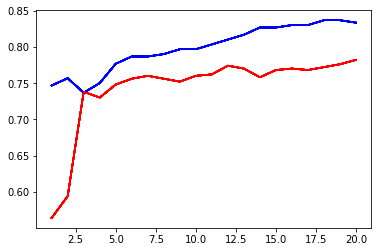

In [0]:
## Accuracy of train and val with Epoch

for i in range(len(epoch)):
  plt.plot(epoch,train_accuracy,'b')
  plt.plot(epoch,val_accuracy,'r')

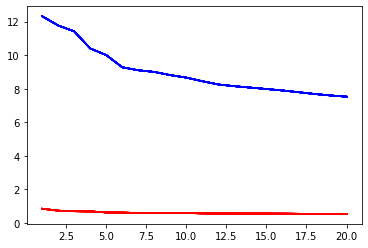

In [0]:
## Loss of train and val with epoch

for i in range(len(epoch)):
  plt.plot(epoch,train_loss,'b')
  plt.plot(epoch,val_loss,'r')

In [0]:
## Save Model

torch.save(variant1.state_dict(), "/content/bestofall_variant_model.pt")

In [0]:
final_model = preds_test.argmax(dim=1).numpy().tolist()
final_model = decode_class_labels(final_model)

In [0]:
##Helper to load and save pytorch models

"""if total_loss_val < temp:
    temp = total_loss_val
    torch.save(network.state_dict(), "/content/best_model.pt")
    print("saved model now")

network.load_state_dict(torch.load("/content/best_model.pt"))
network.eval()"""